In [77]:
import os
import sys
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings("ignore")
DATA_PATH = os.path.join(os.getcwd(), "data")

Для первичного тестирования я буду использовать набор динамики розничной торговли из данного разбора 
https://www.kaggle.com/code/izzettunc/introduction-to-time-series-clustering/notebook
А также воспользуюсь Случано сгенерироваными временными рядами
https://www.kaggle.com/datasets/passwordclassified/synthesised-time-series-data

In [2]:
synthesis_data = pd.read_csv(os.path.join(DATA_PATH, "Synthesised Time Series", "synthesised.csv"), index_col="id")
synthesis_data.head()

,0,1,2,3,4,5,6,7,8,9,...,1096,1097,1098,1099,1100,1101,1102,1103,1104,1105
id,,,,,,,,,,,,,,,,,,,,,
0,25.0,25.168857,24.715599,24.277916,24.027045,23.903862,23.099880,22.619502,22.450067,22.136750,...,13.623944,13.656542,13.204566,13.414686,13.518331,13.544479,13.619775,13.679345,13.402996,13.557636
1,21.0,20.764716,19.956948,19.710582,19.301341,18.848625,18.033900,17.989180,17.485504,16.503814,...,16.071742,16.353189,16.918663,17.026205,17.213205,17.646249,17.883727,17.636658,19.453180,20.057058
2,19.0,18.912363,19.582829,19.409292,19.577184,19.987482,20.581422,21.069311,20.915548,21.400714,...,4.488784,4.241661,4.248950,4.143697,4.440768,4.395694,4.133176,4.012145,4.068881,2.916924
3,23.0,22.877990,23.433526,24.324950,24.358498,24.738647,25.654500,25.933526,26.196802,27.099793,...,24.198968,24.048091,23.835752,23.532187,23.426798,23.362099,23.446236,23.666149,21.995872,21.410275
4,25.0,24.971022,24.305882,23.203562,22.440854,21.559851,20.203296,19.479367,18.399220,17.679928,...,10.499446,10.827831,8.113812,8.583054,8.555737,9.514210,9.333950,9.496314,9.628866,8.863811


In [3]:
def plot_time_series(data, title, num_samples=100):
    plt.figure(figsize=(20, 5))
    plt.title(title)
    for i in range(num_samples):
        plt.plot(data.iloc[i], linewidth=0.5)
    
    plt.xticks([])
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.grid(True, which="both", axis="both")
    plt.show()

C:\Users\andre\AppData\Local\Temp\ipykernel_18352\18037862.py:7: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([])


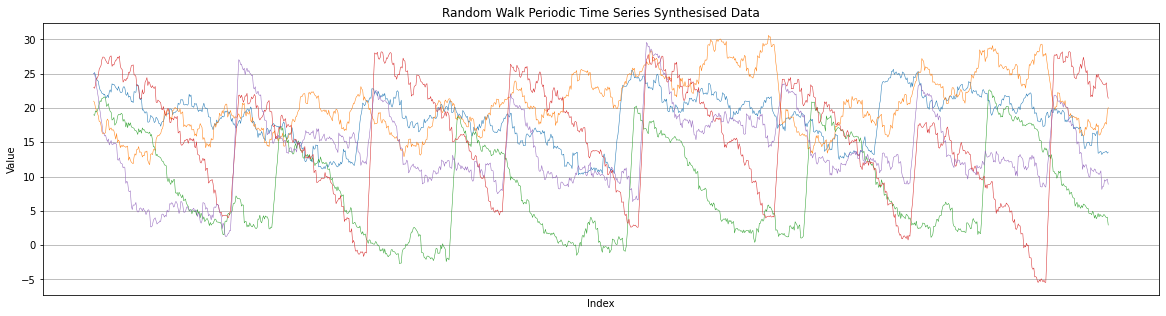

In [4]:
plot_time_series(synthesis_data, "Random Walk Periodic Time Series Synthesised Data", 5)

Для начала перескалируем данные

In [6]:
scaled_synthesis_data = scale_data(synthesis_data)

C:\Users\andre\AppData\Local\Temp\ipykernel_18352\18037862.py:7: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([])


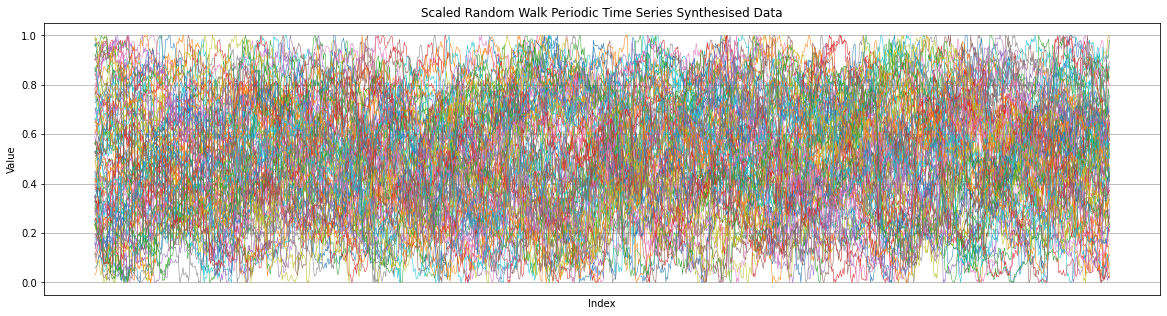

In [48]:
plot_time_series(scaled_synthesis_data, "Scaled Random Walk Periodic Time Series Synthesised Data", 100)

# Протестируем линейную интерполяцию 

C:\Users\andre\AppData\Local\Temp\ipykernel_18352\18037862.py:7: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([])


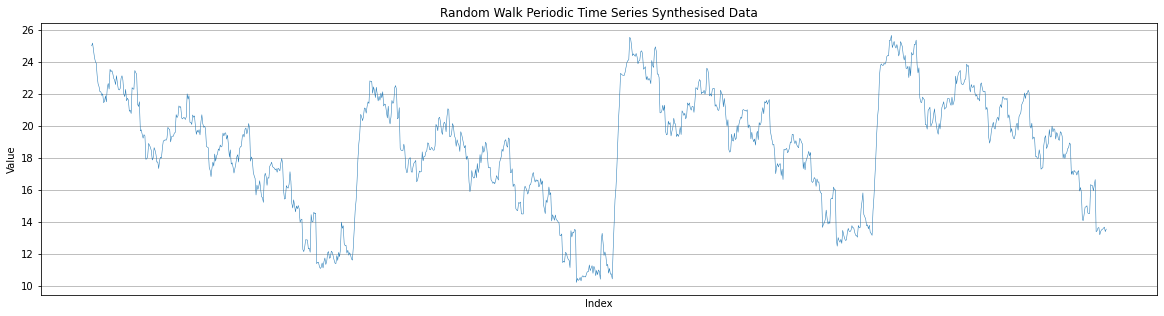

In [8]:
plot_time_series(synthesis_data, "Random Walk Periodic Time Series Synthesised Data", 1)

In [42]:
def get_linear_approximation(data, num_samples=100):
    linear_approximation = data.iloc[:,::len(data) // num_samples]
    return linear_approximation

In [87]:
lin_app_data = get_linear_approximation(synthesis_data, 10)

C:\Users\andre\AppData\Local\Temp\ipykernel_18352\3739495720.py:6: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([])


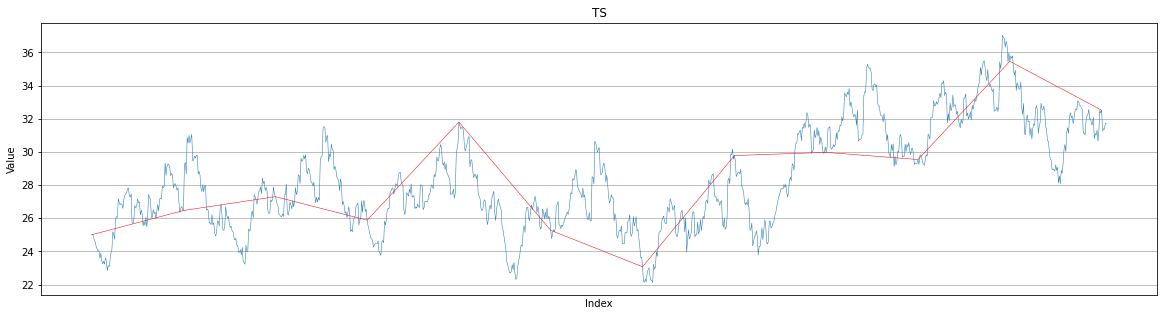

In [47]:
plt.figure(figsize=(20, 5))
plt.title("TS")
plt.plot(synthesis_data.iloc[15], linewidth=0.5)
plt.plot(lin_app_data.iloc[15], linewidth=0.5, color="red")
    
plt.xticks([])
plt.xlabel("Index")
plt.ylabel("Value")
plt.grid(True, which="both", axis="both")
plt.show()

Попробуем теперь обучить на упрощённых данных модель кластеризации

In [50]:
from sklearn.cluster import KMeans

def get_kmeans_clusters(data, num_clusters=10):
    kmeans = KMeans(num_clusters)
    kmeans.fit(data)
    return kmeans.labels_

In [75]:
def plot_clusters(data, num_clusters=10):
    fig, axs = plt.subplots(nrows=num_clusters // 2, ncols=2, figsize=(17,15))
    plt.subplots_adjust(hspace=0.5)
    fig.suptitle("Clusters", fontsize=18, y=0.95)

    for i, ax in enumerate(axs.ravel()):
        ax.set_title(f"Cluster {i}")
        cluster_data = data[data["cluster"] == i].iloc[:,:-1]
        for j in range(len(cluster_data)):
            ax.plot(cluster_data.iloc[j], linewidth=0.5)
        ax.set_xticks([])
        ax.set_xlabel("Index")
        ax.set_ylabel("Value")
        ax.grid(True, which="both", axis="both")
    plt.show()

In [92]:
def test_clusters(data, num_clusters=10):
    data_copy = data.copy()
    lables = get_kmeans_clusters(data_copy, num_clusters)
    print(len(lables))
    print(len(data))
    data_copy["cluster"] = lables
    plot_clusters(data_copy.iloc[:100], num_clusters)

1000
1000


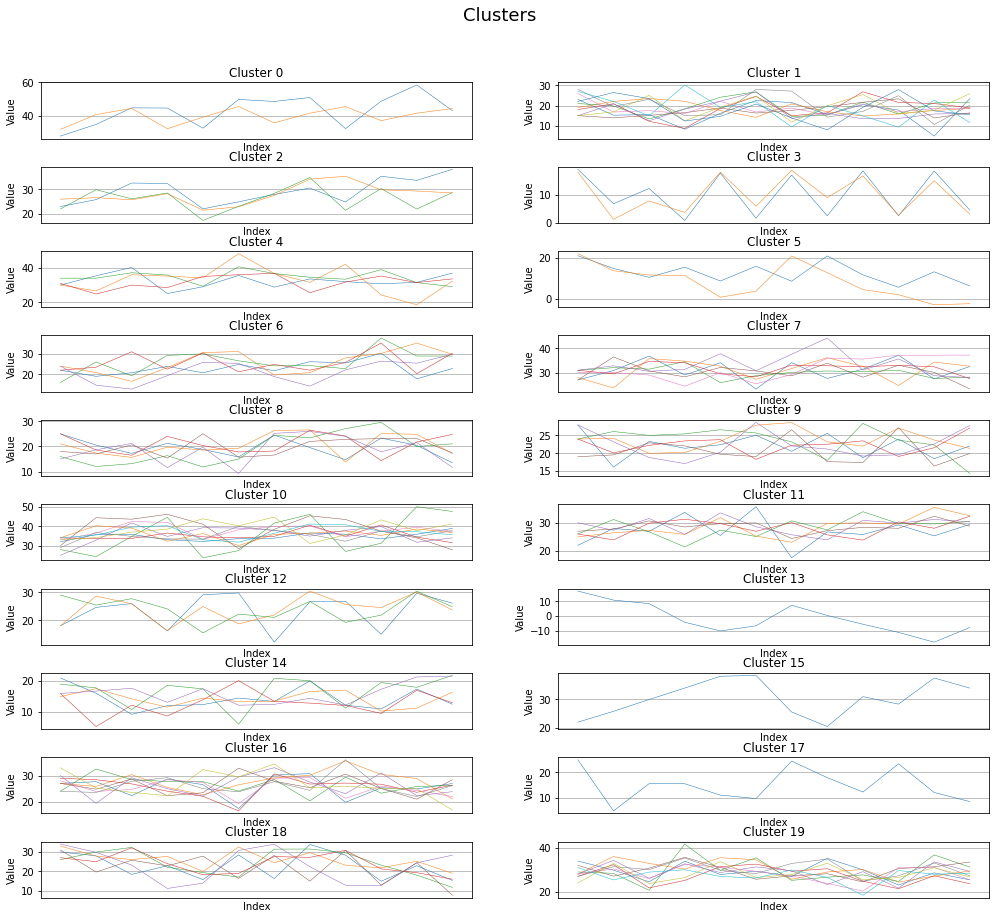

In [94]:
test_clusters(lin_app_data, num_clusters=20)